# predicting health coverage in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has private health insurance (or not) based on demographic data in the PUMS. 

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay

In [2]:
datadir = os.path.join(os.getcwd(),"raw_data")
interimdatadir = os.path.join(os.getcwd(),"interim_data")
figdir = os.path.join(os.getcwd(),"plots")
modeldir = os.path.join(os.getcwd(),"models")

In [3]:
# load pre-processed/scaled training data:
X_train  = pd.read_pickle(os.path.join(interimdatadir,'X_scaled_train.pkl'))
y_train  = pd.read_pickle(os.path.join(interimdatadir,'y_train.pkl'))

X_test  = pd.read_pickle(os.path.join(interimdatadir,'X_scaled_test.pkl'))
y_test  = pd.read_pickle(os.path.join(interimdatadir,'y_test.pkl'))

codedict, code = utils.getCodeDictionary()

In [4]:
xgbmdl  = pickle.load(open(os.path.join(modeldir,'XGBClassifier'),'rb'))

In [5]:
# what were the best model parameters of those searched?
print(xgbmdl.estimator)
print(xgbmdl.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': None, 'scale_pos_weight': 3.0, 'subsample': 0.8}


In [6]:
important_features = xgbmdl.best_estimator_.get_booster().get_score(importance_type='weight')
important_scores   = list(important_features.values())
important_features = list(important_features.keys())
impfeat = pd.DataFrame({'features':important_features,'scores':important_scores})
impfeat = impfeat.sort_values('scores',ascending=False)
descriptor = list()
for feature in impfeat['features']:
    if feature.__contains__('_'):
        name  = feature[0:feature.index('_')]
        num   = feature[feature.index('_')+1:]
        deets = utils.variableDetails(name)
        try:
            val = deets['values']['item'][num]
        except:
            num = str(num).zfill(2)
            val = deets['values']['item'][num]
        descriptor.append(deets['label'] + ':' + val)
    else:
        descriptor.append(codedict[feature])
impfeat['description'] = descriptor

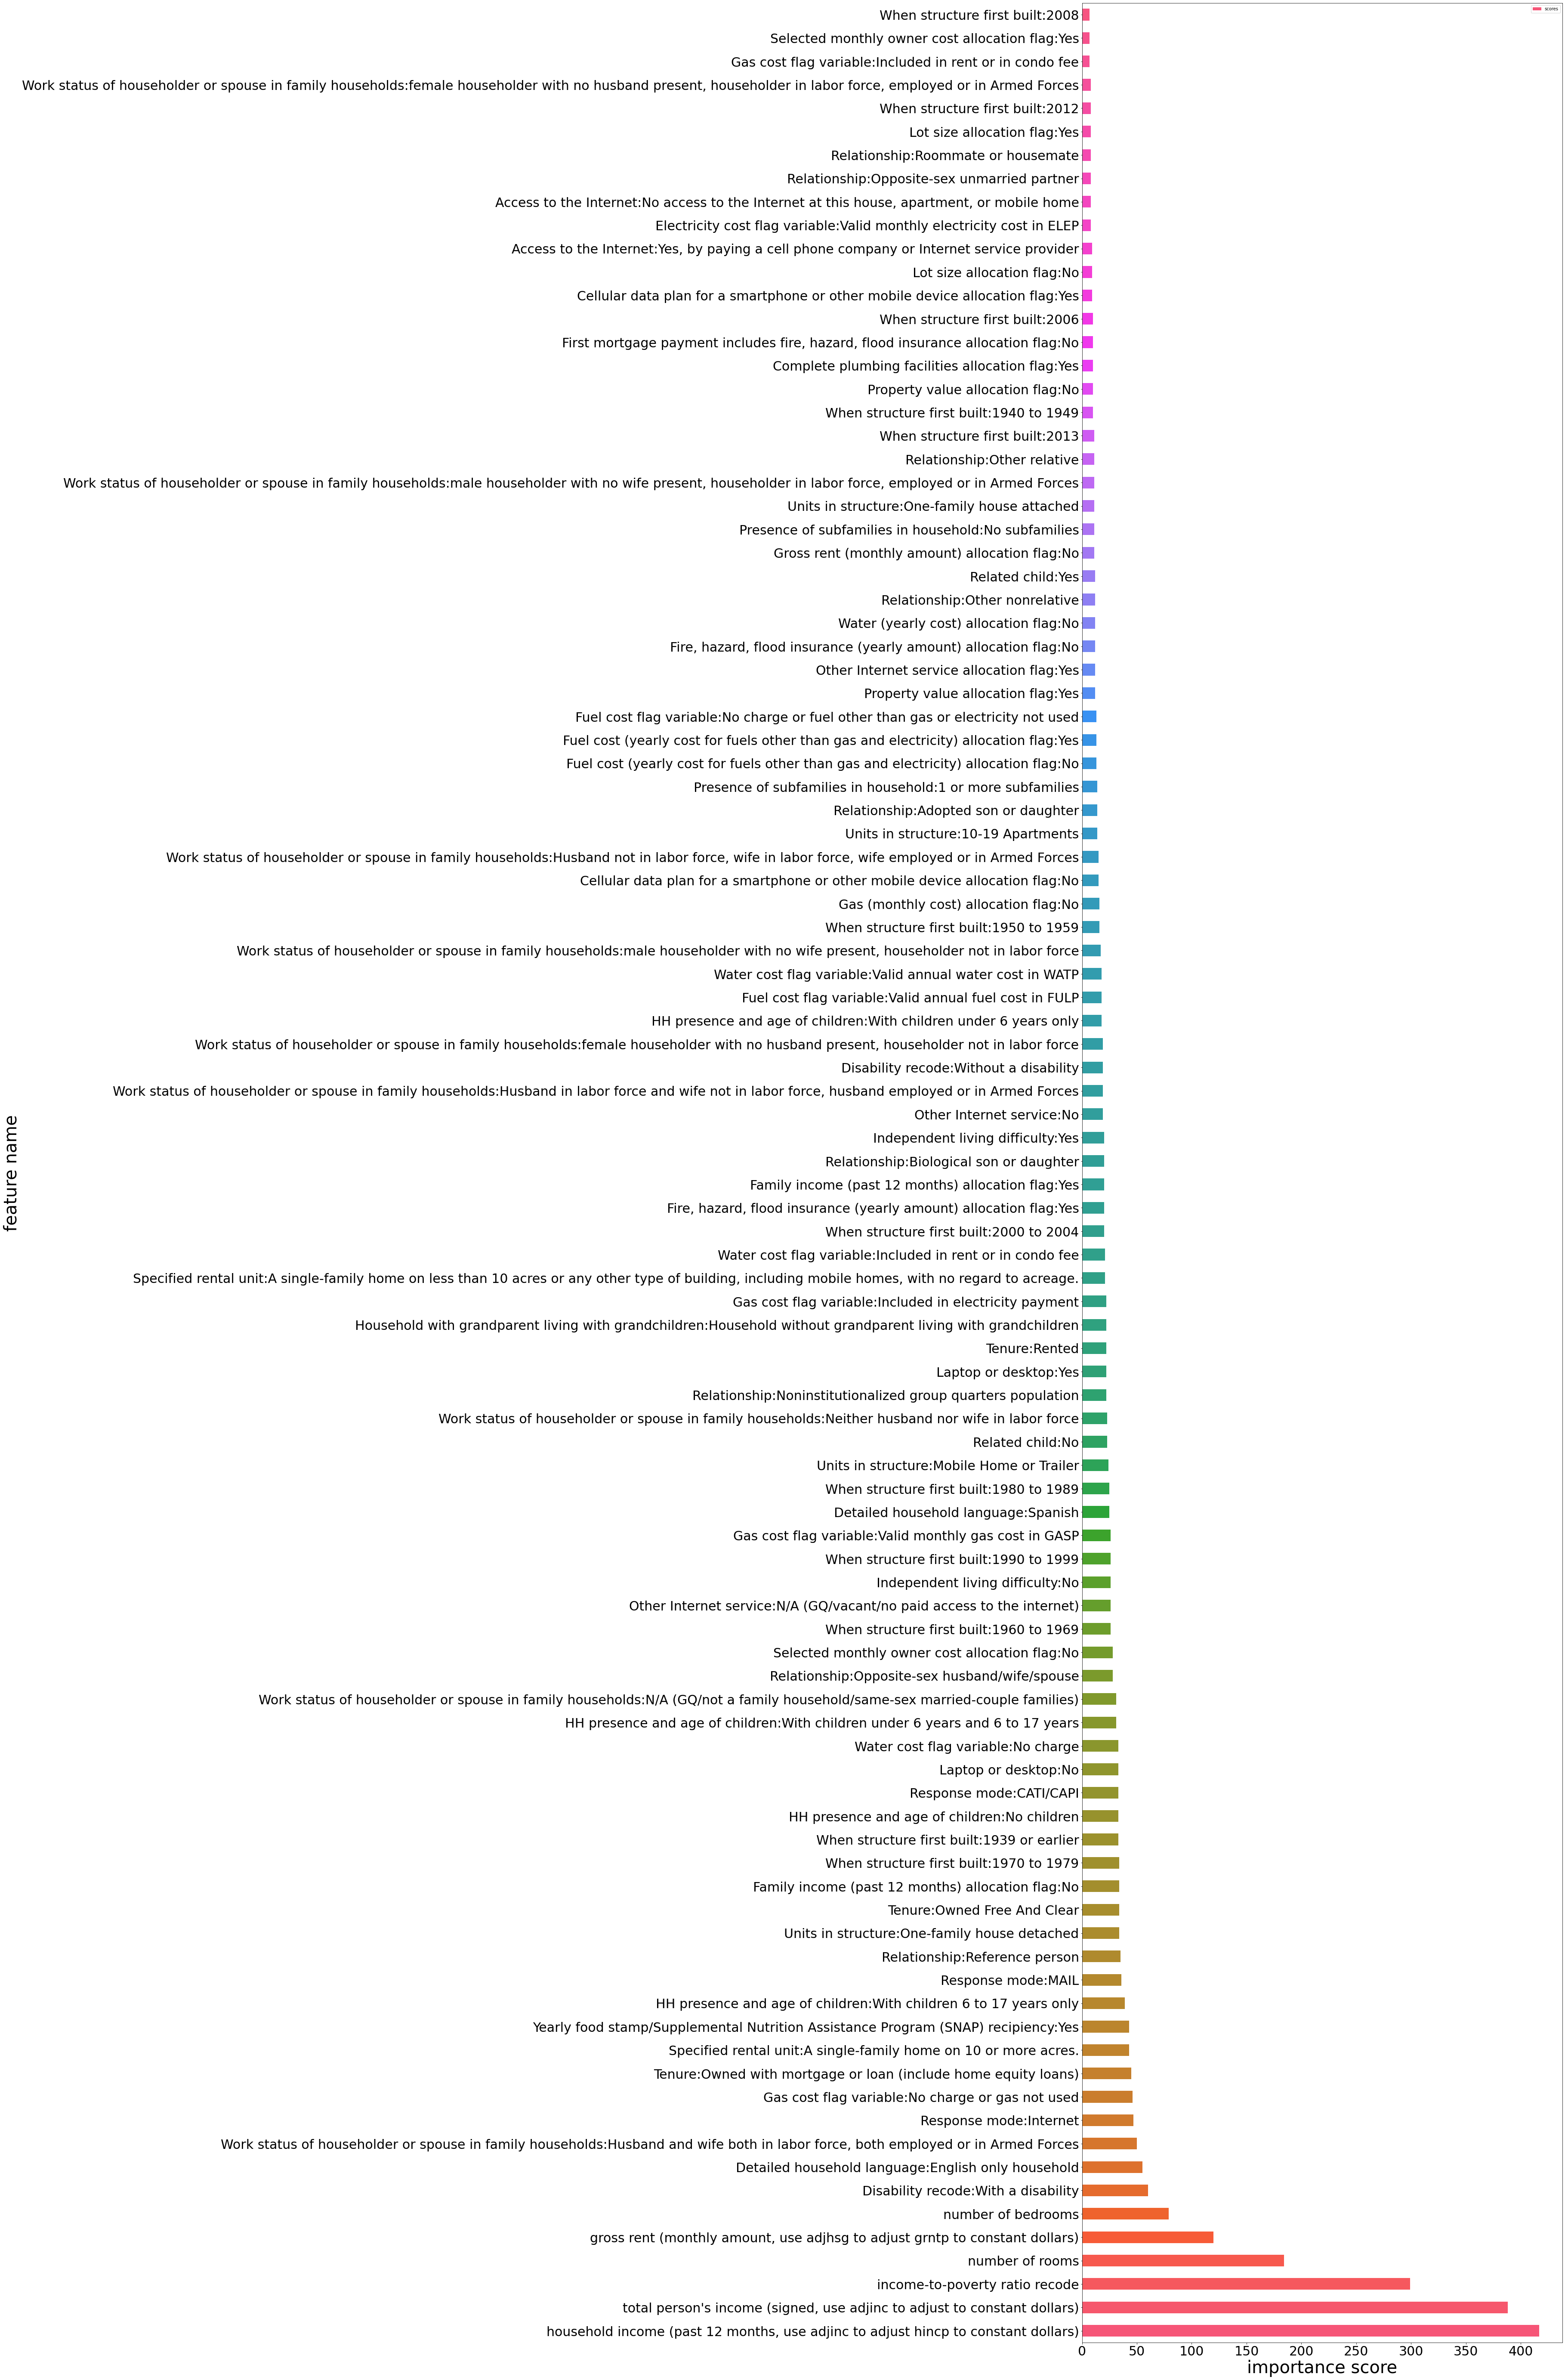

In [7]:
topfeat = impfeat.nlargest(100,'scores')
fig = plt.figure(figsize=(20,100))
ax = fig.add_subplot(111) 
colors = sns.husl_palette(n_colors=int(100), h=0.01, s=0.9, l=0.6, as_cmap=False)
topfeat.plot(x='description',y='scores',kind='barh',color=colors,ax=ax,fontsize=30)
plt.xlabel('importance score',fontsize=40)
plt.ylabel('feature name',fontsize=40)
plt.show()

figname = os.path.join(figdir,'xgboost_importantfeatures.png')
fig = ax.get_figure()
fig.savefig(figname,dpi=None,orientation='portrait', transparent=True,bbox_inches='tight')

In [8]:
cnt = 0
feat = dict()
for feature in impfeat['features']:
    feat[feature] = impfeat['description'][cnt]
    cnt += 1

In [9]:
outcome = X_test[topfeat['features']]
y_pred  = xgbmdl.predict(X_test)
yes_yes = (y_pred == 1) & (y_test == 1)
yes_no  = (y_pred == 1) & (y_test == 0)
no_yes  = (y_pred == 0) & (y_test == 1)
no_no   = (y_pred == 0) & (y_test == 0)

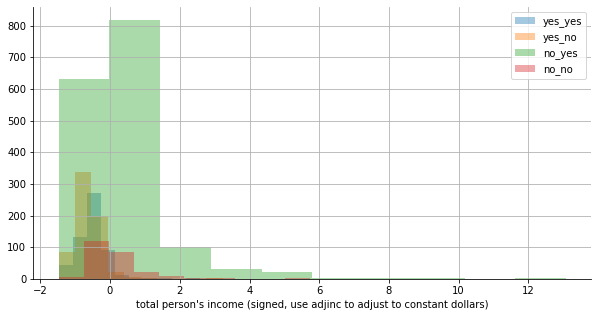

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111) 
alpha = 0.4
outcome['HINCP'].loc[yes_yes].hist(ax=ax,alpha=alpha)
outcome['HINCP'].loc[yes_no].hist(ax=ax,alpha=alpha)
outcome['HINCP'].loc[no_yes].hist(ax=ax,alpha=alpha)
outcome['HINCP'].loc[no_no].hist(ax=ax,alpha=alpha)
sns.despine()
plt.legend(labels=['yes_yes','yes_no','no_yes','no_no'])
plt.xlabel(feat['HINCP'])
plt.show()

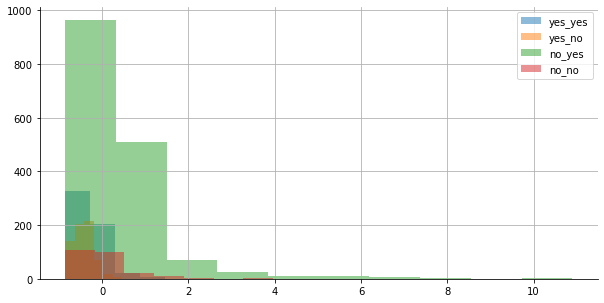

In [12]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111) 
outcome['PINCP'].loc[yes_yes].hist(ax=ax,alpha=0.5)
outcome['PINCP'].loc[yes_no].hist(ax=ax,alpha=0.5)
outcome['PINCP'].loc[no_yes].hist(ax=ax,alpha=0.5)
outcome['PINCP'].loc[no_no].hist(ax=ax,alpha=0.5)
sns.despine()
plt.legend(labels=['yes_yes','yes_no','no_yes','no_no'])
plt.show()